<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/ImageCaptioningUsingCNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Resource: https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/
# https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb
# https://www.youtube.com/watch?v=7Np_5Q-P8eo&list=PLyqSpQzTE6M9gCgajvQbc68Hk_JKGBAYT&index=113

# After completing this tutorial, you will know:

# About the Flickr8K dataset comprised of more than 8,000 photos and up to 5 captions for each photo.
# How to generally load and prepare photo and text data for modeling with deep learning.
# How to specifically encode data for two different types of deep learning models in Keras.

In [2]:
# A good dataset to use when getting started with image captioning is the Flickr8K dataset.
# The reason is that it is realistic and relatively small so that you can download it and build models on your workstation using a CPU.

# The dataset is available for free. You must complete a request form and the links to the dataset will be emailed to you.
# I would love to link to them for you, but the email address expressly requests: “Please do not redistribute the dataset“.
# Request Form: https://illinois.edu/fb/sec/1713398

# Within a short time, you will receive an email that contains links to two files:

# Flickr8k_Dataset.zip (1 Gigabyte) An archive of all photographs.
# Flickr8k_text.zip (2.2 Megabytes) An archive of all text descriptions for photographs.
# UPDATE (Feb/2019): The official site seems to have been taken down (although the form still works). 
# Here are some direct download links from my datasets GitHub repository:
# https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip



In [3]:

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 
from pickle import dump, load
from os import listdir
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization, Input)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
import os
import time
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
import numpy as np
from tensorflow.keras.utils import plot_model


In [4]:
# How to Load Photographs

# The image file names are unique image identifiers. For example, here is a sample of image file names:
# 990890291_afc72be141.jpg
# 99171998_7cc800ceef.jpg
# 99679241_adc853a5c0.jpg
# 997338199_7343367d7f.jpg
# 997722733_0cb5439472.jpg

# We can use the img_to_array() keras function to convert the loaded data.

# We may want to use a pre-defined feature extraction model, such as a state-of-the-art deep image classification network trained on Image net. 
# The Oxford Visual Geometry Group (VGG) model is popular for this purpose and is available in Keras.

# If we decide to use this pre-trained model as a feature extractor in our model, we can preprocess the pixel data for
#  the model by using the preprocess_input() function in Keras, for example:

# It is possible to use a pre-trained model to extract the features from photos in the dataset and store the features to file.
# This is an efficiency that means that the language part of the model that turns features extracted from the photo 
# into textual descriptions can be trained standalone from the feature extraction model. 
# The benefit is that the very large pre-trained models do not need to be loaded, held in memory, and used to process 
# each photo while training the language model.

# Later, the feature extraction model and language model can be put back together for making predictions on new photos.


def extract_features(directory):
    features = dict()

    # load the model
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer, pooling='avg')
    print(model.summary())

    # The two Dense output layers as well as the classification output layer are removed from the model by setting include_top=False.
    # The output from the final pooling layer is taken as the features extracted from the image.

    # Next, we can walk over all images in the directory of images and call predict() 
    # function on the model for each prepared image to get the extracted features. The features can then be stored in 
    # a dictionary keyed on the image id.

    n = 0
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

        n += 1

        if n % 100 == 0:
            print("Done", n)

    return features

BASE_PATH = '/content/drive/MyDrive/ImageCaptioning/'
file_path = os.path.join(BASE_PATH, 'features.pkl')

if os.path.exists(file_path):
    features_file = open(file_path, 'rb')     
    features = load(features_file) 

    features_file.close()   
else:
    # load images
    directory = BASE_PATH + 'Flicker8k_Dataset/Flicker8k_Dataset'

    features = extract_features(directory)
    print('Extracted Features: %d' % len(features))

    # save to file
    dump(features, open('features.pkl', 'wb'))

In [6]:
# These features can then be loaded later and used as input for training a language model.

# You could experiment with other types of pre-trained models in Keras.

In [7]:
# How to Load Descriptions

# It is important to take a moment to talk about the descriptions; there are a number available.

# The file Flickr8k.token.txt contains a list of image identifiers (used in the image filenames) and tokenized descriptions. 
# Each image has multiple descriptions.

# Below is a sample of the descriptions from the file showing 5 different descriptions for a single image.

# 1305564994_00513f9a5b.jpg#0 A man in street racer armor be examine the tire of another racer 's motorbike .
# 1305564994_00513f9a5b.jpg#1 Two racer drive a white bike down a road .
# 1305564994_00513f9a5b.jpg#2 Two motorist be ride along on their vehicle that be oddly design and color .
# 1305564994_00513f9a5b.jpg#3 Two person be in a small race car drive by a green hill .
# 1305564994_00513f9a5b.jpg#4 Two person in race uniform in a street car .

# The file ExpertAnnotations.txt indicates which of the descriptions for each image were written
# by “experts”, which were written by crowdsource workers asked to describe the image.

# Finally, the file CrowdFlowerAnnotations.txt provides the frequency of crowd workers 
# that indicate whether captions suit each image. These frequencies can be interpreted probabilistically.

# There are also lists of the photo identifiers to use in a train/test split so that 
# you can compare results reported in the paper.

# The first step is to decide which captions to use. The simplest approach is to use the
#  first description for each photograph.

# First, we need a function to load the entire annotations file (‘Flickr8k.token.txt‘) into memory.
# Below is a function to do this called load_doc() that, given a filename, will return 
# the document as a string.


In [8]:
# moving file to drive
if not os.path.exists(file_path):
    !mv features.pkl '/content/drive/MyDrive/ImageCaptioning/'

In [9]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
 
	# read all text
	text = file.read()
 
	# close the file
	file.close()
 
	return text

In [10]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()

    # # Maximum length of a caption (in words)
    max_length = 0

	# process lines
    for line in doc.split('\n'):
		# split line by white space
        tokens = line.split()

        if len(line) < 2:
            continue

        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]

        # remove filename from image id, taking only image_id without extension
        image_id = image_id.split('.')[0]

        max_length = max(max_length,len(image_desc))

        # convert description tokens back to string
        image_desc = ' '.join(image_desc)

        # store the first description for each image
        if image_id not in mapping:
            mapping[image_id] = image_desc

    return mapping, max_length

filename = '/content/drive/MyDrive/ImageCaptioning/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)

descriptions, max_length = load_descriptions(doc)

print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [11]:

# Prepare Description Text

# The descriptions are tokenized; this means that each token is comprised of words separated
# by white space.

# It also means that punctuation are separated as their own tokens, such as periods (‘.’) and 
# apostrophes for word plurals (‘s).

# It is a good idea to clean up the description text before using it in a model.
# Some ideas of data cleaning we can form include:

# Normalizing the case of all tokens to lowercase.
# Remove all punctuation from tokens.
# Removing all tokens that contain one or fewer characters (after punctuation is removed), 
# e.g. ‘a’ and hanging ‘s’ characters.

# clean description text
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
 
	for key, desc in descriptions.items():
		# tokenize
		desc = desc.split()
  
		# convert to lower case
		desc = [word.lower() for word in desc]

		# remove punctuation from each token
		desc = [w.translate(table) for w in desc]

		# remove hanging 's' and 'a'
		desc = [word for word in desc if len(word)>1]
		
        # store as string
		descriptions[key] =  ' '.join(desc)

In [12]:
import string

# clean descriptions
clean_descriptions(descriptions)

# all sentences
all_captions = descriptions.values()

# summarize vocabulary
all_words = ' '.join(all_captions).split()
unique_word_count = set(all_words)
print('Vocabulary Size: %d' % len(unique_word_count))

# Reducing voacb size, by taking all the words having word_count >= THRESHOLD
word_count_threshold = 5
word_counts = {}

for sent in all_captions:
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed vocab %d ==> %d' % (len(unique_word_count), len(vocab)))


Vocabulary Size: 4484
preprocessed vocab 4484 ==> 1195


In [13]:
# The vocabulary was still relatively large. To make modeling easier, especially the 
# first time around, I would recommend further reducing the vocabulary by removing
#  words that only appears greater than THRESHOLD across all descriptions

In [14]:
# Next, we build two lookup tables for this vocabulary. The table idxtoword converts
#  index numbers to actual words to index values. The wordtoidx lookup table performs the opposite.

idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1

In [15]:
print(max_length)

38


In [16]:
START = "startseq"
STOP = "endseq"
EPOCHS = 10

In [17]:
# Build the sequences. We include a start and stop token at the beginning/end. 
# We will later use the start token to begin the process of generating a caption. 
# Encountering the stop token in the generated text will let us know the process is complete.

In [18]:
for key, sent in descriptions.items():
    sent_mod = START + ' ' + sent + ' ' + STOP
    descriptions[key] = sent_mod

In [19]:
# Since we have added START and STOP tokens for every sentence
max_length += 2

In [20]:
# Using a Data Generator

# Up to this point, we've always generated training data ahead of time and fit the neural network to it. 
# It is not always practical to create all of the training data ahead of time. The memory demands 
# can be considerable. If we generate the training data as the neural network needs it, 
# it is possible to use a Keras generator. The generator will create new data as it is needed. 
# The generator provided here creates the training data for the caption neural network, as it is needed.

# If we were to build all needed training data ahead of time, it would look like Figure 


<img src="https://camo.githubusercontent.com/c73259c22376b40060d05571a8731781d1058771/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6a656666686561746f6e2f7438315f3535385f646565705f6c6561726e696e672f6d61737465722f696d616765732f63617074696f6e2d322e706e67" />

In [21]:
# checking the output dimensions of vgg
print( features.get('990890291_afc72be141').shape )

(1, 512)


In [22]:
OUTPUT_DIM = 512

In [23]:
# For more on pad_sequences: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc in descriptions.items():
        
        photo = photos.get(key)
        if photo is None:
            continue
        
        n+=1
        
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]

        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            # x2
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            # y
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        
            x1.append( photo.reshape(OUTPUT_DIM)  )
            x2.append(in_seq)
            y.append(out_seq)

        if n == num_photos_per_batch:
            yield ([np.array(x1), np.array(x2)], np.array(y))
            x1, x2, y = [], [], []
            n = 0

In [24]:
# Loading Glove Embeddings

embeddings_index = {} 

f = open(os.path.join(BASE_PATH, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:27, 14693.53it/s]

Found 400000 word vectors.


In [25]:
# testing the embedding
the_representation = embeddings_index.get('the')
print(the_representation.shape)

(200,)


In [26]:
# Building the Neural Network
# We build an embedding matrix from Glove. We will directly copy this matrix to the weight matrix of the neural network.


embedding_dim = 200
vocab_size = len(idxtoword) + 1 

# Get 200-dim dense vector for each of the words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [27]:
embedding_matrix.shape

(1196, 200)

In [28]:

# For x1 
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# For x2
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [29]:
caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 200)      239200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           input_1[0][0]                    
______________________________________________________________________________________________

In [30]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

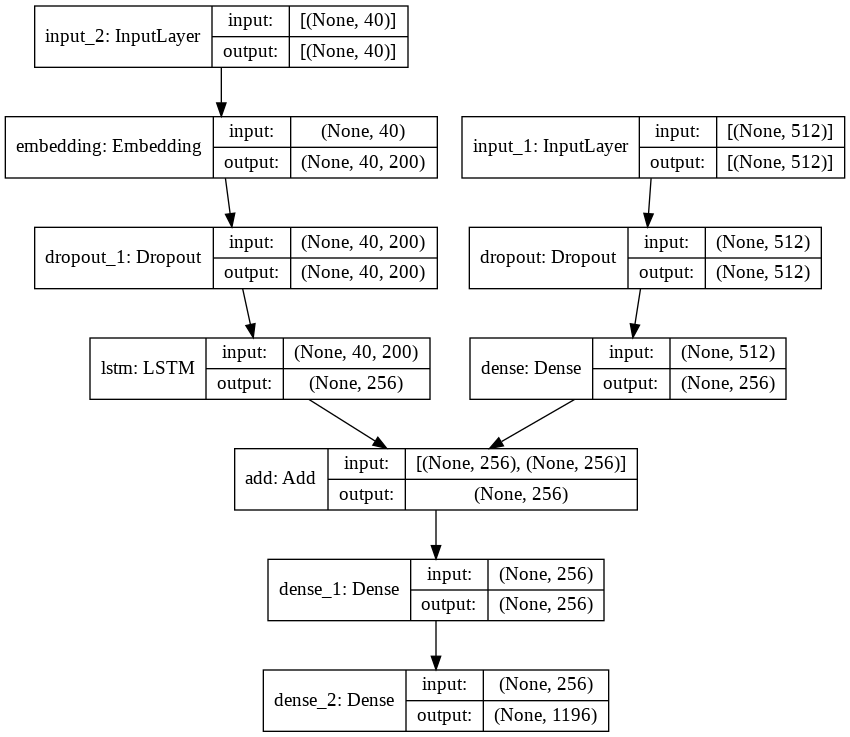

In [31]:
plot_model(caption_model, show_shapes=True)

In [32]:
number_pics_per_batch = 3
steps = len(features) // number_pics_per_batch

In [33]:
steps

2697

In [34]:
# checking the shapes if they are proper input
generator = data_generator(descriptions, features, wordtoidx, max_length, number_pics_per_batch)
for item in generator:
    x1 = item[0][0] # image
    x2 = item[0][1] # input sentence
    y = item[1] # output word prediction
    print(x1.shape, x2.shape, y.shape)
    break

(32, 512) (32, 40) (32, 1196)


In [35]:
model_path = os.path.join(BASE_PATH,f'caption-model.hdf5')

if not os.path.exists(model_path):
    for i in tqdm(range(EPOCHS*2)):
        generator = data_generator(descriptions, features, wordtoidx, max_length, number_pics_per_batch)

        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    # Reducing the lr and increasing batch size and again training for more epochs
    caption_model.optimizer.lr = 1e-4
    number_pics_per_batch = 6
    steps = len(features) // number_pics_per_batch

    for i in range(EPOCHS):
        generator = data_generator(descriptions, features, wordtoidx, max_length, number_pics_per_batch)
        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1) 

    caption_model.save_weights(model_path)
    print(f"\Training took: {hms_string(time()-start)}")
else:
    caption_model.load_weights(model_path)

In [36]:
if not os.path.exists(model_path):
    !mv caption-model.hdf5 '/content/drive/MyDrive/ImageCaptioning/'

In [47]:
# Generating Captions
# It is essential to understand that we do not generate a caption with one single call to the neural network's 
# predict function. Neural networks output a fixed-length tensor. To get a variable-length output, such as free-form text, 
# requires multiple calls to the neural network.

# The neural network accepts two objects (which we map to the input neurons). The first input is the photo, and the 
# second input is an ever-growing caption. The caption begins with just the starting token. The neural network's
#  output is the prediction of the next word in the caption. The caption continues to grow until the neural network predicts 
#  an end token, or we reach the maximum length of a caption.

# I forgot to add the START and STOP in the vocab :(, therefore directly setting it to the first and last element of wordtoidx
def generateCaption(photo):
    in_text = START
    
    wordtoidx[START] = 1
    wordtoidx[STOP] = 1195

    idxtoword[1] = START
    idxtoword[1195] = STOP

    # making it as (1, 512), 1 indicates the number of samples
    photo = np.expand_dims( photo, axis = 0 )

    for i in range(max_length):
        # at first iteration sequence will be 39 zeros and one wordtoidx[START], 
        # say yhat=prediction at first timestep, therefore in_text will be "wordtoidx[START] yhat" and therefore sequence will be 38 zeros
        # at second timestep
          
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]

        # reshaping it as (1, 40), again 1 indicates number of samples
        sequence = pad_sequences([sequence], maxlen=max_length).reshape(1, -1)
        
        # taking the prediction for the first sample
        yhat = caption_model.predict([photo,sequence], verbose=0)[0]
        
        yhat = np.argmax(yhat)
        
        word = idxtoword[yhat]
        
        in_text += ' ' + word
        
        if word == STOP:
            break

    final_text = in_text.split()
    final_text = final_text[1:-1]
    final_text = ' '.join(final_text)
    return final_text

In [38]:
file_name = 'elephant.jpg'
filepath = os.path.join( BASE_PATH, file_name )

image = load_img(filepath, target_size=(224, 224))

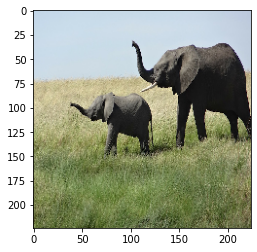

In [39]:
import matplotlib.pyplot as plt

plt.imshow(image)

In [40]:

# convert the image pixels to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# prepare the image for the VGG model
image = preprocess_input(image)

In [41]:
in_layer = Input(shape=(224, 224, 3))
model = VGG16(include_top=False, input_tensor=in_layer, pooling='avg')

58892288/58889256 [==============================] - 2s 0us/step


In [48]:
encoding = model.predict(image).reshape(OUTPUT_DIM)
predicted_caption = generateCaption(encoding)

In [49]:
print(predicted_caption)

in red shirt is running through the grass with stick in his mouth on the beach with his arms in the air on the beach in the background with an adult and her dog in the background is playing


In [ ]:
# this caption makes little bit of sense as it is able to detect the playground, grass, playing and creature like dog.
# Although I forgot to add the START and STOP in the vocabulary which is very big mistake, and model was using the transfer 
# learning from vgg for image encodings and also trasnfer learning from glove 200d for embedding of words.
# If we start the tranining of new model from scratch it would take alot of the time.
